# Purpose
The Purpose of this notebook is explore data fetching, storing, processing, training models, exporting them and loading them.
This why, we can work with larger data sets, evaluate which data features are important, and learn the ins and outs of training, exporting and reusing models on different timeframes, etc.

In [3]:
!pip install yfinance numpy pandas scikit-learn statsmodels joblib
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np


from IPython.core.display import clear_output
clear_output()

# Data Fetching and Processing

In [7]:
############################################################################################################
# Define Technical Indicators Functions
############################################################################################################
def bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    data['Bollinger_High'] = rolling_mean + (rolling_std * num_std)
    data['Bollinger_Low'] = rolling_mean - (rolling_std * num_std)
    return data

def macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

def rsi(data, periods=14, ema=True):
    close_delta = data['Close'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    if ema:
        ma_up = up.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
        ma_down = down.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
    else:
        ma_up = up.rolling(window=periods).mean()
        ma_down = down.rolling(window=periods).mean()
    rsi = ma_up / ma_down
    data['RSI'] = 100 - (100 / (1 + rsi))
    return data

def woodie_pivots(data):
    high = data['High']
    low = data['Low']
    close = data['Close']
    pivot = (high + low + 2 * close) / 4
    data['Pivot'] = pivot
    data['R1'] = 2 * pivot - low
    data['S1'] = 2 * pivot - high
    data['R2'] = pivot + (high - low)
    data['S2'] = pivot - (high - low)
    data['R3'] = high + 2 * (pivot - low)
    data['S3'] = low - 2 * (high - pivot)
    data['R4'] = pivot + 3 * (high - low)
    data['S4'] = pivot - 3 * (high - low)
    return data

def obv(data):
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                           np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0)).cumsum()
    return data

def atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    data['ATR'] = true_range.rolling(window=window).mean()
    return data

def stochastic_oscillator(data, window=14):
    low_min = data['Low'].rolling(window=window).min()
    high_max = data['High'].rolling(window=window).max()
    data['%K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    data['%D'] = data['%K'].rolling(window=3).mean()
    return data
############################################################################################################
# Process other non-stationary data
############################################################################################################
# Function to detrend time series data using a linear regression model
def detrend_data(data, column):
    # Linear regression model requires reshaped index as a feature
    X = np.arange(len(data)).reshape(-1, 1)
    y = data[column].values  # Original values to detrend
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the trend
    trend = model.predict(X)
    
    # Detrend by subtracting the trend from the original data
    detrended = y - trend
    data[f'{column}_detrended'] = detrended
    
    # Return the detrended data and the trend for further analysis
    return data, trend

def seasonal_decomposition(data, column, period):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(data[column], model='multiplicative', period=period)
    
    # Add components to DataFrame
    data['trend_component'] = decomposition.trend
    data['seasonal_component'] = decomposition.seasonal
    data['residual_component'] = decomposition.resid
    
    # Seasonally adjust the data
    data[column + '_seasonally_adjusted'] = data[column] / data['seasonal_component']
    
    return data

# Function to calculate price differences
def calculate_price_differences(data, column):
    data[f'{column}_diff'] = data[column].diff()
    return data

# Function to calculate log returns
def calculate_log_returns(data, column):
    data[f'{column}_log_return'] = np.log(data[column] / data[column].shift(1))
    return data

# Function to calculate volume changes
def calculate_volume_changes(data, volume_column):
    data[f'{volume_column}_changes'] = data[volume_column].diff()
    return data


############################################################################################################
# Fetch Financial Data Function with Technical Indicators
############################################################################################################
def fetch_financial_data(ticker='SPY', start_year=1993, end_year=None, interval='1d', export_csv=False, csv_file=None,  calculate_indicators=False,):
    """
    Fetches data for a specified ticker from Yahoo Finance from the given start year to the current year or specified end year at specified intervals.
    
    Parameters:
        ticker (str): The ticker symbol for the asset. Defaults to 'SPY'.
        start_year (int): The year from which to start fetching the data. Defaults to 1993.
        end_year (int): The last year for which to fetch the data. Defaults to the current year if None.
        interval (str): The data interval ('1d' for daily, '1wk' for weekly, '1mo' for monthly, '1h' for hourly).
        export_csv (bool): Whether to export the data to a CSV file. Defaults to False.
        csv_file (str): The path of the CSV file to export the data to. Automatically determined if None.
    """
    # If end_year is not specified, use the current year
    # Hourly data can only be fetched for the last 730 days
    if end_year is None:
        end_year = pd.Timestamp.today().year
        
    # If csv_file is not specified, automatically generate a file name based on the ticker and interval
    if csv_file is None:
        csv_file = f'{ticker}_{interval}_data_{start_year}_to_{end_year}.csv'
    
    # Adjust end_date to ensure data is fetched through the end of the end_year
    end_date = f"{end_year}-12-31"
    
    # Download the data before attempting to access it
    data = yf.download(ticker, start=f'{start_year}-01-01', end=end_date, interval=interval)
    
    # Ensure 'data' has been successfully downloaded and is not empty
    if not data.empty and calculate_indicators:
        data = bollinger_bands(data)
        data = macd(data)
        data = rsi(data)
        data = woodie_pivots(data)
        data = obv(data)
        data = atr(data)
        data = stochastic_oscillator(data)

        # Non-stationary data processing
        data = calculate_price_differences(data, 'Close')  # Calculate price differences
        data = calculate_log_returns(data, 'Close')  # Calculate log returns for the 'Close' column
        data = calculate_volume_changes(data, 'Volume')  # Calculate volume changes


    else:
        print("Data download failed or returned an empty DataFrame.")
    
    if export_csv and not data.empty:
        data.to_csv(csv_file)
        print(f'Data exported to {csv_file}')
    
    return data 
############################################################################################################
# Example usage
############################################################################################################
spy_data_daily = fetch_financial_data(ticker='SPY', interval='1d', export_csv=True, calculate_indicators=True)  # Daily data for SPY
# aapl_data_weekly = fetch_financial_data(ticker='AAPL', interval='1wk', start_year=2000, export_csv=True)  # Weekly data for AAPL starting from 2000


[*********************100%%**********************]  1 of 1 completed

Data exported to SPY_1d_data_1993_to_2024.csv


In [6]:
spy_data_daily

,Open,High,Low,Close,Adj Close,Volume,Bollinger_High,Bollinger_Low,MACD,Signal,...,S3,R4,S4,OBV,ATR,%K,%D,Close_diff,Close_log_return,Volume_changes
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763742,1003200,NaN,NaN,0.000000,0.000000,...,43.609375,44.554688,43.242188,0,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939873,480500,NaN,NaN,0.024929,0.004986,...,43.828125,45.023438,43.335938,480500,NaN,NaN,NaN,0.312500,0.007087,-522700.0
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992689,201300,NaN,NaN,0.051654,0.014319,...,43.968750,45.046875,43.546875,681800,NaN,NaN,NaN,0.093750,0.002116,-279200.0
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256899,529400,NaN,NaN,0.109398,0.033335,...,44.109375,46.117188,43.304688,1211200,NaN,NaN,NaN,0.468750,0.010515,328100.0
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362579,531500,NaN,NaN,0.168349,0.060338,...,44.062500,46.765625,43.015625,1742700,NaN,NaN,NaN,0.187500,0.004175,2100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,510.480011,511.880005,508.500000,511.279999,509.696350,62557200,517.641141,493.520856,5.937663,6.233759,...,506.209991,520.875015,500.594986,8817297100,4.719999,71.857342,80.220782,-0.440002,-0.000860,-23868300.0
2024-03-12,513.450012,517.380005,510.859985,516.780029,515.179321,73114400,519.207137,493.534861,6.125060,6.212019,...,507.000000,535.010071,495.889954,8890411500,4.913572,90.526690,78.675217,5.500031,0.010700,10557200.0
2024-03-13,517.109985,517.289978,514.489990,515.969971,514.371826,55104100,519.602899,495.328098,6.137459,6.197107,...,511.769989,524.329941,507.530014,8835307400,4.307857,83.296177,81.893403,-0.810059,-0.001569,-18010300.0


# Validate Data

In [8]:
def test_data_quality(data):
    """
    Tests the data for quality and consistency.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing financial data.
    
    Returns:
        dict: A dictionary containing the test results.
    """
    results = {}

    # Test for NaN values
    nan_count = data.isna().sum().sum()
    results['total_nan_count'] = nan_count

    # Test for detrending
    detrended_columns = [col for col in data.columns if 'detrended' in col]
    results['detrended_columns'] = detrended_columns
    if detrended_columns:
        results['detrending_test'] = "Detrended columns found."
    else:
        results['detrending_test'] = "No detrended columns found."

    # Check for log returns and price differences
    log_return_columns = [col for col in data.columns if 'log_return' in col]
    price_diff_columns = [col for col in data.columns if '_diff' in col]
    results['log_return_columns'] = log_return_columns
    results['price_diff_columns'] = price_diff_columns

    # Check for volume changes
    volume_change_columns = [col for col in data.columns if 'volume_changes' in col]
    results['volume_change_columns'] = volume_change_columns

    # Statistical checks for detrended columns
    for col in detrended_columns:
        mean = data[col].mean()
        std_dev = data[col].std()
        results[f'{col}_mean'] = mean
        results[f'{col}_std_dev'] = std_dev

    return results

# Example usage
# Assuming 'spy_data_daily' is a DataFrame obtained from the fetch_financial_data function and includes some of the processed columns
spy_data_daily = pd.DataFrame()  # Placeholder for the actual spy_data_daily DataFrame
test_results = test_data_quality(spy_data_daily)
print(test_results)


{'total_nan_count': 0.0, 'detrended_columns': [], 'detrending_test': 'No detrended columns found.', 'log_return_columns': [], 'price_diff_columns': [], 'volume_change_columns': []}


# Feature Engineering

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

def prepare_data(data, target_columns, shift_target_by=-1):
    """
    Prepares features and target by selecting the correct columns and shifting the target.

    Parameters:
        data (pd.DataFrame): The input DataFrame with all the data.
        target_columns (list): The list of columns to be used as target.
        shift_target_by (int): The number of rows to shift the target by for prediction.

    Returns:
        tuple: Tuple containing the features and target DataFrames.
    """
    # Check if target columns exist
    missing_targets = [col for col in target_columns if col not in data.columns]
    if missing_targets:
        raise ValueError(f"The following target columns are missing from the data: {missing_targets}")
    
    # Assume all other columns are features
    feature_columns = [col for col in data.columns if col not in target_columns]
    
    # Handle missing values
    data = data.dropna(subset=feature_columns + target_columns)

    # Select features and target
    features = data[feature_columns]
    target = data[target_columns].shift(shift_target_by)

    # Drop the rows with NaN values in the target
    valid_indices = target.dropna().index
    features = features.loc[valid_indices]
    target = target.dropna()

    return features, target

""

def split_data(features, target, test_size=0.2, random_state=42):
    """
    Splits features and target into training and testing sets.

    Parameters:
        features (pd.DataFrame): Features DataFrame.
        target (pd.DataFrame): Target DataFrame.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: Tuple containing the split data.
    """
    return train_test_split(features, target, test_size=test_size, random_state=random_state)

def train_model(X_train, y_train, n_estimators=100, random_state=42):
    """
    Trains a RandomForestRegressor model on the provided data.

    Parameters:
        X_train (pd.DataFrame): The training features.
        y_train (pd.DataFrame): The training target.
        n_estimators (int): The number of trees in the forest.
        random_state (int): Random state for reproducibility.

    Returns:
        RandomForestRegressor: The trained model.
    """
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    # Flatten y_train to a 1D array if it's not already
    y_train = y_train.values.flatten() if isinstance(y_train, pd.DataFrame) else y_train
    model.fit(X_train, y_train)
    return model

def evaluate_feature_importances(model, feature_columns):
    """
    Evaluates and prints the feature importances of the model.

    Parameters:
        model (RandomForestRegressor): The trained model.
        feature_columns (list): The list of columns that were used as features.

    Returns:
        None
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for f in range(len(feature_columns)):
        print(f"{f + 1}. feature {feature_columns[indices[f]]} ({importances[indices[f]]})")

# Example usage
# Fetching the financial data with indicators
spy_data_daily = fetch_financial_data(ticker='SPY', interval='1d', export_csv=False, calculate_indicators=True)

# Preparing the data by specifying target columns
# The target is one day ahead 'Close' price
target_columns = ['Close']
shift_target_by = -1  # we shift by -1 to predict the next day's close

# Preparing features and target datasets
features, target = prepare_data(spy_data_daily, target_columns, shift_target_by)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = split_data(features, target)

# Training the model
model = train_model(X_train, y_train)

# Evaluating the feature importances
feature_columns_used = features.columns.tolist()
evaluate_feature_importances(model, feature_columns_used)

[*********************100%%**********************]  1 of 1 completed


Feature ranking:
1. feature Pivot (0.2803179564334346)
2. feature R1 (0.22025032197087324)
3. feature Adj Close (0.10971281508757999)
4. feature Bollinger_High (0.08357767702484269)
5. feature R3 (0.07392140044028939)
6. feature S1 (0.0694960500694793)
7. feature R4 (0.06809635703832095)
8. feature Low (0.03798025386362145)
9. feature S2 (0.02691045314061592)
10. feature R2 (0.013756279666242792)
11. feature High (0.0086867074687146)
12. feature Open (0.006803079674645041)
13. feature S3 (0.00019863642608457068)
14. feature Bollinger_Low (0.00011174512975427988)
15. feature OBV (2.2783722852902323e-05)
16. feature S4 (2.0821127273749065e-05)
17. feature Signal (1.7546588036298038e-05)
18. feature ATR (1.63904886946968e-05)
19. feature Volume (1.607109317570946e-05)
20. feature Volume_changes (1.5884108019389012e-05)
21. feature MACD (1.5255672777093098e-05)
22. feature %D (1.2263812917034614e-05)
23. feature RSI (1.1420687603864342e-05)
24. feature %K (1.1389164682580446e-05)
25. featu

# Export Trained Model

In [37]:
import joblib

# Save the model to a file
joblib.dump(model, 'trained_SPY_random_forest_model.joblib')


['trained_SPY_random_forest_model.joblib']

In [39]:
# Load the model from the file
loaded_model = joblib.load('trained_SPY_random_forest_model.joblib')

# Use the loaded model to make predictions
predictions = loaded_model.predict(X_test)  # Assuming X_test is available in this context


# Forecast With Trained Model

In [13]:
spy_data_hourly = fetch_financial_data(ticker='SPY', interval='1h', export_csv=False, calculate_indicators=True) 


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SPY']: Exception('%ticker%: 1h data not available for startTime=728317800 and endTime=1710693705. The requested range must be within the last 730 days.')


Data download failed or returned an empty DataFrame.


[*********************100%%**********************]  1 of 1 completed


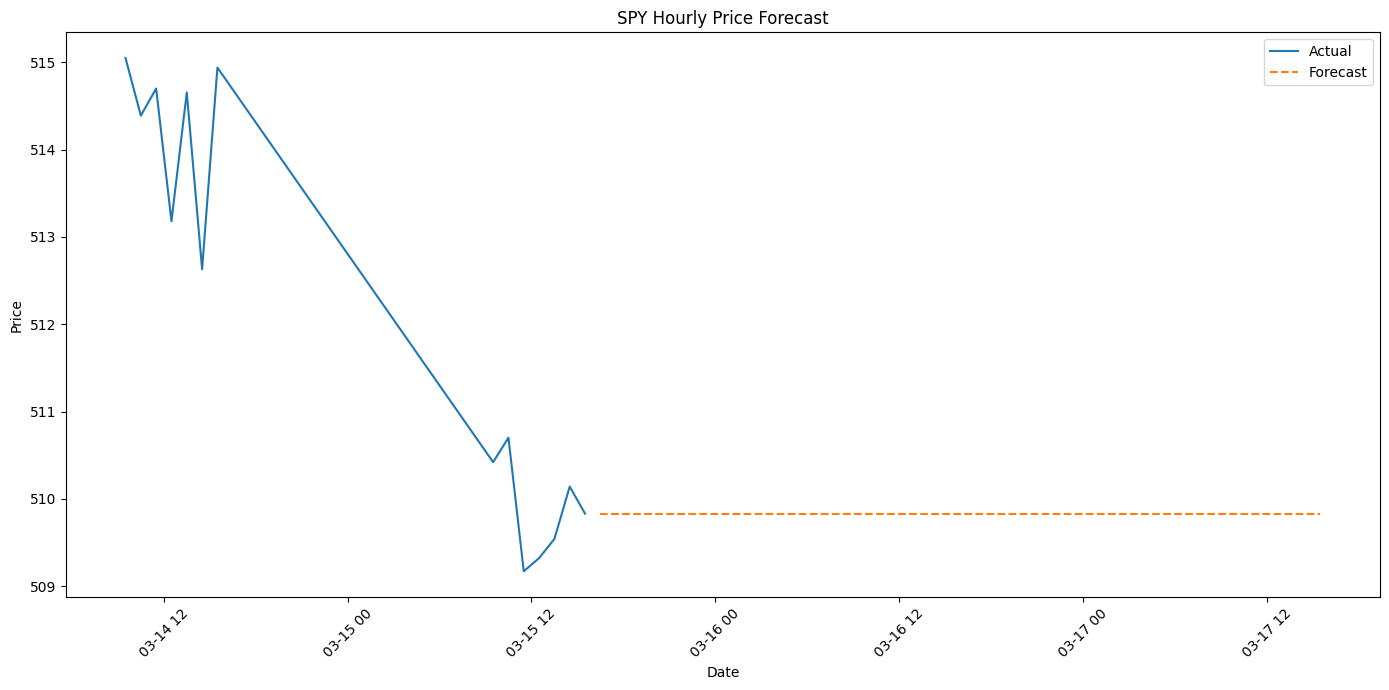

In [14]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import joblib

# Load the model from the file
loaded_model = joblib.load('trained_SPY_random_forest_model.joblib')

# Get today's date and the date for 3 days ago
end_date = datetime.now()
start_date = end_date - timedelta(days=3)

# Fetch the hourly data for the last 3 days
data = yf.download('SPY', start=start_date, end=end_date, interval='1h')

# Assuming the prepare_data function includes all necessary preprocessing steps
# (including dealing with non-stationary data, scaling, etc.),
# prepare your X_test set. This part is highly dependent on your preprocessing steps.
# Here is just a placeholder for the actual code:
# X_test = prepare_data(data, target_columns=['Close'])

# The model was trained to predict one day ahead 'Close' price based on the past data,
# so let's replicate this structure for our test set.
# You will also need to match the columns to your trained model's expectations.
# We will have to modify `prepare_data` function accordingly if necessary.

# Use the loaded model to make predictions for the next 2 days, but you will need
# to prepare the data incrementally for each prediction if your model was not trained
# on sequential data (as in time series models).

# As a placeholder for actual predictions, using the last known values:
predictions = [data['Close'].iloc[-1]] * 48  # 48 hours in 2 days

# Add your actual prediction code here

# Now let's plot the actual and forecasted values.
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual')
plt.plot([data.index[-1] + timedelta(hours=i) for i in range(1, 49)], predictions, label='Forecast', linestyle='--')
plt.legend()
plt.title('SPY Hourly Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
